# Эксперименты с QQ-plot

## Подготовка


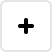
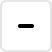
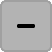
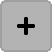
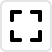
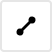
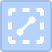
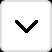
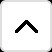
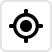

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform, t, gamma, expon, chi2

from lets_plot import *
from lets_plot.mapping import as_discrete
LetsPlot.setup_html()

In [2]:
def plot_matrix(plots=[], width=400, height=300, columns=2):
    bunch = GGBunch()
    for i in range(len(plots)):
        row = int(i / columns)
        column = i % columns
        bunch.add_plot(plots[i], column * width, row * height, width, height)
    return bunch.show()

In [3]:
def distributions(dist_name=None):
    d = {
        "norm": {
            "dist": norm,
            "def_params": [],
            "color": "#1b9e77",
        },
        "uniform": {
            "dist": uniform,
            "def_params": [],
            "color": "#d95f02",
        },
        "t": {
            "dist": t,
            "def_params": [1],
            "color": "#7570b3",
        },
        "gamma": {
            "dist": gamma,
            "def_params": [1],
            "color": "#e7298a",
        },
        "exp": {
            "dist": expon,
            "def_params": [],
            "color": "#66a61e",
        },
        "chi2": {
            "dist": chi2,
            "def_params": [1],
            "color": "#e6ab02",
        },
    }
    if dist_name in d.keys():
        return d[dist_name]
    else:
        return d

def stat_qq(input_df, column, dist="norm", dparams=None):
    n = input_df[column].size
    t = (np.arange(1, n + 1) - .5) / n
    dparams = dparams or distributions(dist)["def_params"]
    stat_x = distributions(dist)["dist"].ppf(t, *dparams)
    stat_y = input_df[column].sort_values(ignore_index=True)

    return pd.DataFrame({"x": stat_x, "y": stat_y})

def stat_qq_line(input_df, column, dist="norm", dparams=None, quantiles=[.25, .75]):
    stat = stat_qq(input_df, column, dist, dparams)
    x_start, x_end = np.quantile(stat["x"], quantiles, interpolation="nearest")
    y_start, y_end = np.quantile(stat["y"], quantiles, interpolation="nearest")
    slope = (y_end - y_start) / (x_end - x_start)
    intercept = y_start - slope * x_start
    
    return {"x": stat["x"],
            "y": stat["x"] * slope + intercept,
            "inner": np.where((stat["x"] >= x_start)&(stat["x"] <= x_end), 1, 0)}

def stat_qq_curve(input_df, column, dist_x="norm", dparams_x=None, dist_y="norm", dparams_y=None, n=1_000):
    x = (np.arange(1, n + 1) - .5) / n
    dparams_x = dparams_x or distributions(dist_x)["def_params"]
    stat_x = distributions(dist_x)["dist"].ppf(x, *dparams_x)
    dist = distributions(dist_y)["dist"]
    dparams_y = dparams_y or dist.fit(input_df[column])
    stat_y = dist.ppf(x, *dparams_y)

    return pd.DataFrame({"x": stat_x, "y": stat_y})

def bistro_qq_bunch(_aes, _data, quantiles=[.25, .75], point_alpha=.4, line_alpha=.2):
    sample_aes = _aes.as_dict()["sample"]
    ymin, ymax = _data[sample_aes].min(), _data[sample_aes].max()
    plots = []
    for dist, t in distributions().items():
        plots.append(ggplot() + geom_qq(_aes, data=_data, distribution=dist, \
                                        color=t["color"], alpha=point_alpha, \
                                        tooltips=layer_tooltips().line(dist)) + \
            geom_line(aes("x", "y", alpha=as_discrete("inner")), \
                      data=stat_qq_line(_data, sample_aes, dist=dist, quantiles=quantiles), \
                      color=t["color"], size=1, show_legend=False) + \
            scale_alpha_manual(values=[line_alpha, 1.0]) + \
            ylim(ymin, ymax) + \
            ggtitle(dist))
    return plot_matrix(plots, width=250, height=250, columns=3)

def bistro_qq_curve(_aes, _data, dist="norm", dparams=None):
    sample_aes = _aes.as_dict()["sample"]
    dsize = _data[sample_aes].size
    xmin = distributions(dist)["dist"].ppf(.5 / dsize, *distributions(dist)["def_params"])
    xmax = distributions(dist)["dist"].ppf(1.0 - .5 / dsize, *distributions(dist)["def_params"])
    ymin = _data[sample_aes].min()
    ymax = _data[sample_aes].max()
    return ggplot() + \
        geom_qq(_aes, data=_data, distribution=dist, dparams=dparams, \
                shape=1, color='black') + \
        geom_line(aes("x", "y", color="dist"), \
                  data=pd.concat([
                      stat_qq_curve(_data, sample_aes, dist_x=dist, dparams_x=dparams, dist_y=dist_name).assign(dist=lambda x: dist_name)
                      for dist_name in distributions().keys()
                  ], ignore_index=True), \
                  size=2, alpha=.5) + \
        xlim(xmin, xmax) + ylim(ymin, ymax)

def qqplot(data=None, sample=None, x=None, y=None,
           show_legend=None,
           distribution=None, dparams=None, quantiles=None,
           group=None,
           alpha=.5, size=3, line_size=.75, color=None, fill=None, line_color=None, shape=None, linetype=None):
    aesthetics = {}
    qq_layer = None
    qq_line_layer = None
    if not sample is None:
        assert x is None and y is None
        aesthetics['sample'] = sample
        qq_layer = geom_qq
        qq_line_layer = geom_qq_line
    else:
        assert not x is None and not y is None
        aesthetics['x'] = x
        aesthetics['y'] = y
        qq_layer = geom_qq2
        qq_line_layer = geom_qq2_line
    if not group is None:
        aesthetics["group"] = group
        aesthetics["color"] = as_discrete(group)
        aesthetics["fill"] = as_discrete(group)
    else:
        line_color='black'
    return ggplot(data, aes(**aesthetics)) + \
        qq_layer(show_legend=show_legend, \
                 distribution=distribution, dparams=dparams, \
                 color=color, fill=fill, alpha=alpha, size=size, shape=shape) + \
        qq_line_layer(show_legend=False, \
                      distribution=distribution, dparams=dparams, quantiles=quantiles, \
                      color=line_color, size=line_size, linetype=linetype)

## Демонстрация линии

In [4]:
df = pd.DataFrame({"y": norm.rvs(size=50, random_state=42)})
df.head()

y
0  0.496714
1 -0.138264
2  0.647689
3  1.523030
4 -0.234153

In [5]:
p = ggplot() + \
    geom_qq(aes(sample="y"), data=df, shape=21, color='#118ED8', fill='#14A8FF', alpha=.75)

p1 = p + \
    geom_line(aes("x", "y"), data=stat_qq_line(df, "y")) + \
    ggtitle("Вся прямая в одном стиле")
p2 = p + \
    geom_line(aes("x", "y", alpha=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), show_legend=False) + \
    scale_alpha_manual(values=[0, 1]) + \
    ggtitle("Края линии невидимы")
p3 = p + \
    geom_line(aes("x", "y", alpha=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), size=1, show_legend=False) + \
    scale_alpha_manual(values=[1.0/3.0, 1]) + \
    ggtitle("Края линии полупрозрачны")
p4 = p + \
    geom_line(aes("x", "y", size=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), show_legend=False) + \
    scale_size_manual(values=[.2, .5]) + \
    ggtitle("Края линии тоньше")
p5 = p + \
    geom_line(aes("x", "y", color=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), show_legend=False) + \
    scale_color_manual(values=['#C0C0C0', '#118ED8']) + \
    ggtitle("Края линии серые")
p6 = p + \
    geom_line(aes("x", "y", color=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), show_legend=False) + \
    scale_color_manual(values=['#FFD2FF', 'black']) + \
    ggtitle("Края линии розовые")
p7 = p + \
    geom_line(aes("x", "y", linetype=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), show_legend=False) + \
    scale_linetype_manual(values=[5, 1]) + \
    ggtitle("Края линии пунктиром")
p8 = p + \
    geom_line(aes("x", "y", linetype=as_discrete("inner")), \
              data=stat_qq_line(df, "y"), show_legend=False) + \
    scale_linetype_manual(values=[3, 1]) + \
    ggtitle("Края линии точечным пунктиром")

plot_matrix([p1, p2, p3, p4, p5, p6, p7, p8])

## Демонстрация "bistro"

### `qqplot()`

In [6]:
iris_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/iris.csv")
iris_df.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [7]:
qqplot(iris_df, sample="sepal_length")

In [8]:
qqplot(iris_df, x="sepal_width", y="sepal_length")

In [9]:
qqplot(iris_df, "sepal_length", group="species")

In [10]:
qqplot(iris_df, "sepal_length", group="species", \
       quantiles=[.1, .9],
       shape=21, color='black', alpha=.3, size=5, \
       line_color='black', line_size=.3, \
       show_legend=False)

### `qq_bunch()` & `qq_curve()`

#### Тест с искусственными данными

In [11]:
df = pd.DataFrame({"y": expon.rvs(loc=2, scale=3, size=50, random_state=42)})
df.head()

y
0   3.407804
1  11.030364
2   5.950237
3   4.738828
4   2.508875

In [12]:
bistro_qq_bunch(aes(sample="y"), df)

In [13]:
bistro_qq_curve(aes(sample="y"), df)

#### Тест с данными mpg

In [14]:
mpg_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/mpg.csv")
mpg_df.head()

Unnamed: 0 manufacturer model  displ  year  cyl       trans drv  cty  hwy  \
0           1         audi    a4    1.8  1999    4    auto(l5)   f   18   29   
1           2         audi    a4    1.8  1999    4  manual(m5)   f   21   29   
2           3         audi    a4    2.0  2008    4  manual(m6)   f   20   31   
3           4         audi    a4    2.0  2008    4    auto(av)   f   21   30   
4           5         audi    a4    2.8  1999    6    auto(l5)   f   16   26   

  fl    class  
0  p  compact  
1  p  compact  
2  p  compact  
3  p  compact  
4  p  compact

In [15]:
bistro_qq_bunch(aes(sample="hwy"), mpg_df)

In [16]:
bistro_qq_curve(aes(sample="hwy"), mpg_df)